This project will look at a corpus of 43 speeches from the U.S. Department of State and U.S. Department of Homeland Security related to cybersecurity, from 2009 - 2016. 
It will use various methods on the corpus as a whole, considering the ways in which speeches from both agencies converge and diverge. Then, it will apply various methods to the subsets of DOS speeches and DHS speeches to gain further insights on how they compare. Given that setting is a crucial aspect of security issues, I will narrow my research an analysis on patterns pertaining to cyberspace when possible. 
Finally, I will complement my broader research on the corpus and its subsets with a closer text analysis of a number of speeches. 

In [238]:
import pandas
import os
from os import listdir
from os.path import isfile, join
import re

# Getting Data & Creating Dataframe

In [239]:
targetDir = '/Users/Enya/Desktop/content-analysis-2018/Speeches'

In [240]:
def getText(x):
    reResults = re.findall(r'(TEXT:)(.*?)((END))', x.replace('\n', ' '), flags = re.M)
    return[t[1] for t in reResults]

def getDate(x) :
    reResults = re.findall(r'(DATE:)(.*?)(TITLE)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

def getCategory(x):
    reResults = re.findall(r'(CATEGORY:)(.*?)(SPEECH)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

def getTitle(x):
    reResults = re.findall(r'(TITLE:)(.*?)(TEXT)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

In [241]:
speechestext = []
speechesdate = []
agency = []
title = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding='utf-8') as f:
        workingText = f.read()
        workingText = str(workingText)
        goodText = getText(workingText)
        date = getDate(workingText)
        category = getCategory(workingText)
        speechtitle = getTitle(workingText)
        speechestext += goodText
        speechesdate += date
        agency += category
        title += speechtitle

speechesDF = pandas.DataFrame({'agency':agency, 'date' :speechesdate, 'title':title, 'text':speechestext})

In [242]:
import lucem_illud 

import requests
import nltk
import pandas
import matplotlib.pyplot as plt 
import wordcloud 
import numpy as np
import scipy 
import seaborn as sns 
import sklearn.manifold 
from nltk.corpus import stopwords 
import urllib.parse 

%matplotlib inline

# Tokenizing and Normalizing Text for Future Methods

In [243]:
speechesDF['tokenized-text'] = speechesDF['text'].apply(lambda x: nltk.word_tokenize(x))

In [244]:
stop_words_nltk = stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    return list(workingIter)


speechesDF['normalized-text'] = speechesDF['tokenized-text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

# Vectorizing & tf-idf

In [245]:
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import scipy 
import gensim

In [246]:
speechesCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
speechesVects = speechesCountVectorizer.fit_transform(speechesDF['text'])

In [247]:
speechesCountVectorizer.vocabulary_.get('cyber')

1535

In [248]:
speechesCountVectorizer.vocabulary_.get('cyberspace')

1549

In [249]:
speechesCountVectorizer.vocabulary_.get('cybersecurity')

1548

In [250]:
speechesTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(speechesVects)
speechesTF = speechesTFTransformer.transform(speechesVects)

In [251]:
list(zip(speechesCountVectorizer.vocabulary_.keys(), speechesTF.data))[:20]

[('would', 0.006192151375533132),
 ('like', 0.01651915565340029),
 ('to', 0.3485429253286871),
 ('begin', 0.008685221349322399),
 ('by', 0.057593233841748775),
 ('thanking', 0.015583057346600806),
 ('the', 0.38523165431065415),
 ('un', 0.03808545848968145),
 ('counter', 0.17510021417264782),
 ('terrorism', 0.10943763385790488),
 ('committee', 0.0210894425644009),
 ('ctc', 0.03752378695624622),
 ('and', 0.4035760188016377),
 ('executive', 0.00983777221787942),
 ('directorate', 0.014559700686820718),
 ('cted', 0.01876189347812311),
 ('for', 0.08713573133217177),
 ('organizing', 0.014559700686820718),
 ('this', 0.07037284722288567),
 ('special', 0.011864057480844702)]

In [252]:
speechesTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
speechesTFVects = speechesTFVectorizer.fit_transform(speechesDF['text'])

In [253]:
try:
    print(speechesTFVectorizer.vocabulary_['cyberspace'])
except KeyError:
    print('cyberspace is missing')
    print('The available words are: {} ...'.format(list(speechesTFVectorizer.vocabulary_.keys())[:20]))

cyberspace is missing
The available words are: ['begin', 'counter', 'terrorism', 'committee', 'executive', 'special', 'meeting', 'technical', 'morning', 'pleased', 'participate', 'december', 'issue', 'challenging', 'nature', 'terrorist', 'groups', 'especially', 'isil', 'known'] ...


In [254]:
try:
    print(speechesTFVectorizer.vocabulary_['cyber'])
except KeyError:
    print('cyber is missing')
    print('The available words are: {} ...'.format(list(speechesTFVectorizer.vocabulary_.keys())[:20]))

cyber is missing
The available words are: ['begin', 'counter', 'terrorism', 'committee', 'executive', 'special', 'meeting', 'technical', 'morning', 'pleased', 'participate', 'december', 'issue', 'challenging', 'nature', 'terrorist', 'groups', 'especially', 'isil', 'known'] ...


# K-means Clustering
While I recognize clustering a corpus of 43 speeches does not provide particularly insightful outcomes, I use the method to better understand the relationship between DOS speeches and DHS speeches within the corpus as a whole. Specifically, I aim to determine whether or not they will be clustered separately or, alternatively, have more overlap with each other. As such, I am keeping my number of cluster to 2.

In [255]:
numClusters =2
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [256]:
km.fit(speechesTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [257]:
speechesDF['kmeans_predictions'] = km.labels_

In [258]:
terms = speechesTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 dhs
 homeland
 federal
 nation
 computer
 share
 sharing
 systems
 really
 service


Cluster 1:
 norms
 strategy
 behavior
 stability
 cicte
 north
 korea
 consensus
 freedom
 cybercrime




In [259]:
print("For my clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speechesDF['text'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speechesDF['text'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speechesDF['text'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speechesDF['text'], km.labels_)))

For my clusters:
Homogeneity: 0.178
Completeness: 1.000
V-measure: 0.303
Adjusted Rand Score: 0.000


# Vizualization & PCA of Clusters

In [487]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(speechesTFVects.toarray())
reduced_data = pca.transform(speechesTFVects.toarray())

In [494]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) 
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:] 
y = components[:,keyword_ids][1,:]

In [495]:
colordict = {
' DOS ': 'green',
' DHS ': 'red'
    }
colors = [colordict[c] for c in speechesDF['agency']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(' DOS ', 'green'), (' DHS ', 'red')])


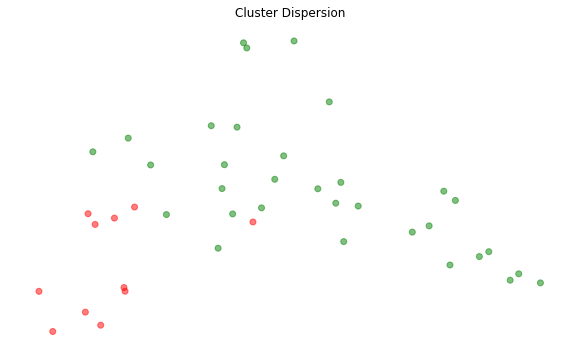

In [496]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('Cluster Dispersion')
plt.show()

fig.savefig('clusters.png', bbox_inches='tight')

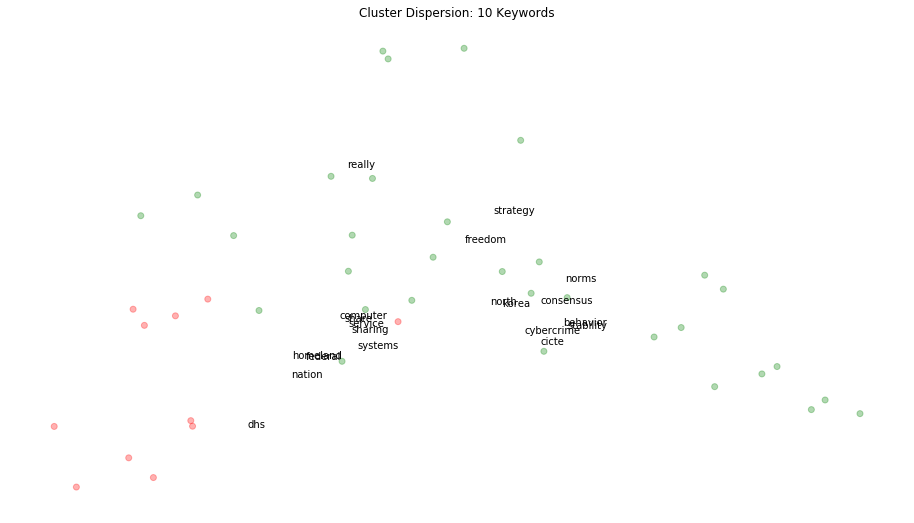

In [498]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Cluster Dispersion: 10 Keywords')
plt.show()

fig.savefig('clusters10kw.png', bbox_inches='tight')

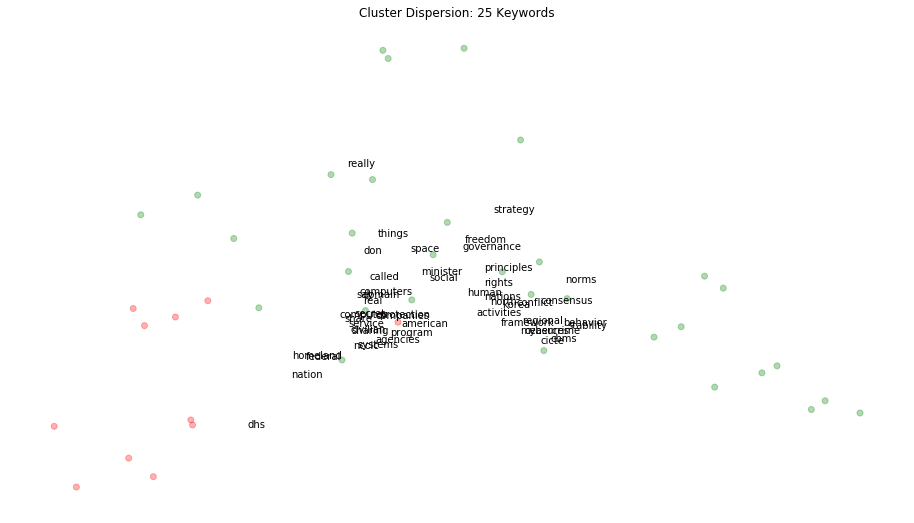

In [265]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:25].flatten())) 
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:] 
y = components[:,keyword_ids][1,:]


fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Cluster Dispersion: 25 Keywords')
plt.show()

# Hierarchical Clustering
Although less useful, below is the code for hierarchical clustering of the 43 speeches.

In [266]:
speechesCoocMat = speechesTFVects * speechesTFVects.T
speechesCoocMat.setdiag(0)

In [267]:
selectIndices = []
indexToCat = []
for c in set(speechesDF['agency']):
    selectIndices += list(speechesDF[speechesDF['agency'] == c].index)[:50]
    indexToCat += [c] * 50

In [268]:
subCoocMat = speechesCoocMat[selectIndices,:][:,selectIndices]

In [269]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 5.        , 22.        ,  0.2848596 ,  2.        ],
       [26.        , 31.        ,  0.30414969,  2.        ],
       [18.        , 29.        ,  0.34241938,  2.        ],
       [32.        , 36.        ,  0.3469917 ,  2.        ],
       [11.        , 25.        ,  0.40079383,  2.        ],
       [45.        , 46.        ,  0.40576627,  4.        ],
       [42.        , 44.        ,  0.4184324 ,  3.        ],
       [ 0.        ,  3.        ,  0.44927515,  2.        ],
       [ 4.        , 10.        ,  0.46216284,  2.        ],
       [43.        , 48.        ,  0.47217778,  6.        ]])

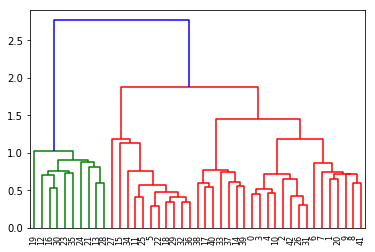

In [270]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

# Topic Modeling Using Gensim

Ended up not being very useful, given the small corpus size.

In [319]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

speechesDF['reduced-tokens'] = speechesDF['normalized-text'].apply(lambda x: dropMissing(x, speechesTFVectorizer.vocabulary_.keys()))

In [320]:
dictionary = gensim.corpora.Dictionary(speechesDF['reduced-tokens'])
corpus = [dictionary.doc2bow(text) for text in speechesDF['reduced-tokens']]
gensim.corpora.MmCorpus.serialize('speeches.mm', corpus)
speechesmm = gensim.corpora.MmCorpus('speeches.mm')

In [321]:
speecheslda = gensim.models.ldamodel.LdaModel(corpus=speechesmm, id2word=dictionary, num_topics=3, alpha='auto', eta='auto')

In [322]:
speechesldaDF = pandas.DataFrame({
        'date' : speechesDF['date'],
        'title' : speechesDF['title'],
        'topics' : [speecheslda[dictionary.doc2bow(l)] for l in speechesDF['reduced-tokens']]
    })

In [323]:
speechestopicsProbDict = {i : [0] * len(speechesldaDF) for i in range(speecheslda.num_topics)}

for index, topicTuples in enumerate(speechesldaDF['topics']):
    for topicNum, prob in topicTuples:
        speechestopicsProbDict[topicNum][index] = prob

for topicNum in range(speecheslda.num_topics):
    speechesldaDF['topic_{}'.format(topicNum)] = speechestopicsProbDict[topicNum]

speechesldaDF

,date,title,topics,topic_0,topic_1,topic_2
0,"December 01, 2016",Preventing the Exploitation of Information an...,"[(0, 0.99228644)]",0.992286,0.000000,0.000000
1,"November 10, 2016",Remarks on International Law and Stability,"[(0, 0.2913524), (1, 0.23178835), (2, 0.476859...",0.291352,0.231788,0.476859
2,"October 10, 2016",Keynote Address at the Singapore Internationa...,"[(0, 0.16596696), (1, 0.7270482), (2, 0.106984...",0.165967,0.727048,0.106985
3,"October 04, 2016",Video Remarks on Cybersecurity Awareness Mont...,"[(0, 0.91092426), (1, 0.050710328), (2, 0.0383...",0.910924,0.050710,0.038365
4,"September 28, 2016",The Persistent Threat of North Korea and Deve...,"[(0, 0.20889066), (1, 0.78834313)]",0.208891,0.788343,0.000000
5,"September 19, 2016",Statement Before the Presidential Commission ...,"[(0, 0.3686205), (1, 0.4156085), (2, 0.21577094)]",0.368621,0.415608,0.215771
6,"June 03, 2016",TEDx Tysons Talk,"[(0, 0.42997116), (1, 0.25741336), (2, 0.31261...",0.429971,0.257413,0.312615
7,"May 25, 2016",Briefing on the State Department Inspector Ge...,"[(0, 0.47276416), (1, 0.21245877), (2, 0.31477...",0.472764,0.212459,0.314777
8,"May 25, 2016",International Cybersecurity Strategy: Deterri...,"[(0, 0.46714908), (1, 0.10335466), (2, 0.42949...",0.467149,0.103355,0.429496
9,"March 01, 2016",Remarks by Attorney General Loretta E. Lynch ...,"[(0, 0.3331754), (1, 0.6274077), (2, 0.03941683)]",0.333175,0.627408,0.039417


In [324]:
speechestopicsDict = {}
for topicNum in range(speecheslda.num_topics):
    topicWords = [w for w, p in speecheslda.show_topic(topicNum)]
    speechestopicsDict['Topic_{}'.format(topicNum)] = topicWords

speecheswordRanksDF = pandas.DataFrame(speechestopicsDict)
speecheswordRanksDF

,Topic_0,Topic_1,Topic_2
0,nation,nation,nation
1,effort,network,share
2,space,partner,effort
3,share,effort,network
4,network,question,homeland
5,region,right,thing
6,discuss,korea,behavior
7,north,share,right
8,partner,program,partner
9,terrorist,north,question


In [330]:
speechesldaDFV = speechesldaDF[:43][['topic_%d' %x for x in range(3)]]
speechesldaDFVisN = speechesldaDF[:10][['date']]
speechesldaDFVis = speechesldaDFV.as_matrix(columns=None)
speechesldaDFVisNames = speechesldaDFVisN.as_matrix(columns=None)
speechesldaDFV

,topic_0,topic_1,topic_2
0,0.992286,0.000000,0.000000
1,0.291352,0.231788,0.476859
2,0.165967,0.727048,0.106985
3,0.910924,0.050710,0.038365
4,0.208891,0.788343,0.000000
5,0.368621,0.415608,0.215771
6,0.429971,0.257413,0.312615
7,0.472764,0.212459,0.314777
8,0.467149,0.103355,0.429496
9,0.333175,0.627408,0.039417


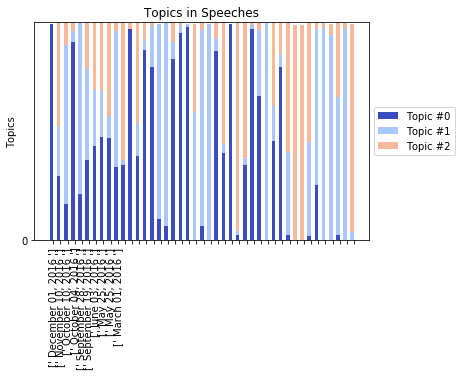

In [331]:
N = 43
ind = np.arange(N)
K = speecheslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, speechesldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, speechesldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += speechesldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Speeches')
plt.xticks(ind+width/2, speechesldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

Unfortunately given the limited number of speeches in my corpus this is not very insightful. The topics have too much overlap with each other. Nevertheless, I figured I would try creating a graph to see what it would look like. 

# Information Extraction

In [277]:
speechesDF['tokenized-sents'] = speechesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
speechesDF['normalized-sents'] = speechesDF['tokenized-sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

In [278]:
speechesW2V = gensim.models.word2vec.Word2Vec(speechesDF['normalized-sents'].sum())

In [279]:
speechesW2V.wv.syn0

array([[ 0.4708911 , -0.08624727, -0.77488935, ..., -0.30018455,
         0.23644327, -0.14502713],
       [ 0.39084533, -0.07011451, -0.6364236 , ..., -0.25783998,
         0.19858873, -0.12049749],
       [ 0.42138043, -0.08834794, -0.6962538 , ..., -0.2732563 ,
         0.20515694, -0.1260996 ],
       ...,
       [ 0.0335044 , -0.00982395, -0.04888061, ..., -0.02141897,
         0.01126745, -0.01291014],
       [ 0.04222889, -0.01268597, -0.07435942, ..., -0.02787179,
         0.02035811, -0.01319063],
       [ 0.02952517, -0.00573122, -0.05957527, ..., -0.0238523 ,
         0.01300775, -0.010625  ]], dtype=float32)

In [280]:
print("A {} dimesional vector:".format(speechesW2V['cyberspace'].shape[0]))
speechesW2V['cyberspace']

A 100 dimesional vector:


array([ 0.38719773, -0.07420488, -0.63475543, -0.2130132 , -0.06544052,
       -0.68415755, -0.08757505,  0.3128043 ,  0.24119863,  0.05568811,
        0.30457404,  0.6009522 , -0.5085855 ,  0.49563542, -0.2702542 ,
        0.5412941 ,  0.19253817, -0.7999046 ,  0.14758347,  0.18265204,
        0.03966085, -0.07393764,  0.12802042,  0.16769429, -0.11159308,
       -0.611715  , -0.25879055,  0.6342689 ,  0.96189547, -0.5591749 ,
       -0.11350769,  0.703533  ,  0.19261833, -0.6227503 ,  0.3765855 ,
        0.40005553,  0.15562522,  0.14885147, -0.6166886 ,  1.1521236 ,
       -0.01515333,  0.19076422,  0.36654636,  0.53779215, -0.2721352 ,
        0.3715135 , -0.4558298 ,  0.47723264,  0.7777021 , -0.4200788 ,
        0.25756603, -0.18185148, -0.48738864,  0.13204205, -0.41816485,
       -0.61797273, -0.86574894, -0.1333388 , -0.227022  ,  0.20519295,
        0.47819763, -0.0261394 , -0.22519243,  0.2874698 ,  0.22835934,
       -0.12166806, -0.03072825, -0.3317369 , -0.6340855 , -0.46

In [281]:
speechesW2V.most_similar('cyber')

[('cybersecurity', 0.9999507069587708),
 ('one', 0.9999491572380066),
 ('new', 0.9999425411224365),
 ('countries', 0.9999411702156067),
 ('work', 0.9999362230300903),
 ('attack', 0.9999361038208008),
 ('need', 0.9999328851699829),
 ('space', 0.9999328851699829),
 ('key', 0.9999326467514038),
 ('also', 0.9999325275421143)]

In [282]:
speechesW2V.most_similar('cybersecurity')

[('including', 0.9999507665634155),
 ('cyber', 0.9999507069587708),
 ('us', 0.9999499917030334),
 ('also', 0.9999482035636902),
 ('information', 0.9999473690986633),
 ('need', 0.9999468922615051),
 ('take', 0.999944806098938),
 ('efforts', 0.9999445080757141),
 ('time', 0.99994295835495),
 ('people', 0.9999426603317261)]

In [283]:
speechesW2V.most_similar('cyberspace')

[('international', 0.9999223947525024),
 ('development', 0.9999154806137085),
 ('law', 0.9999138712882996),
 ('state', 0.9999089241027832),
 ('including', 0.9999063014984131),
 ('threats', 0.9999050498008728),
 ('working', 0.9999033808708191),
 ('must', 0.9999017119407654),
 ('address', 0.9999011754989624),
 ('take', 0.9998990893363953)]

In [284]:
speechesW2V.most_similar(positive=['cyberspace', 'domestic'], negative = ['international'])

[('could', 0.9996917247772217),
 ('cybersecurity', 0.9996852278709412),
 ('people', 0.9996813535690308),
 ('un', 0.9996699094772339),
 ('countries', 0.9996697902679443),
 ('efforts', 0.9996687769889832),
 ('right', 0.9996686577796936),
 ('must', 0.9996660947799683),
 ('president', 0.9996647834777832),
 ('well', 0.9996640086174011)]

In [285]:
speechesW2V.most_similar(positive=['cyberspace', 'international'], negative = ['domestic'])

[('norms', 0.999574601650238),
 ('law', 0.9995585083961487),
 ('enforcement', 0.9995290040969849),
 ('responsible', 0.9994889497756958),
 ('existing', 0.9994886517524719),
 ('development', 0.9994736313819885),
 ('act', 0.9994663000106812),
 ('state', 0.9994655847549438),
 ('address', 0.9994497895240784),
 ('strategy', 0.9994496703147888)]

In [286]:
DOSspeechesW2V = gensim.models.word2vec.Word2Vec(speechesDF['normalized-sents'][0:31].sum())
DHSspeechesW2V = gensim.models.word2vec.Word2Vec(speechesDF['normalized-sents'][32:42].sum())

In [287]:
display(DOSspeechesW2V.most_similar('cyber'))
display(DHSspeechesW2V.most_similar('cyber'))

[('countries', 0.9999520182609558),
 ('new', 0.9999511241912842),
 ('one', 0.9999481439590454),
 ('information', 0.9999481439590454),
 ('work', 0.9999480247497559),
 ('cybersecurity', 0.9999477863311768),
 ('attack', 0.9999465942382812),
 ('internet', 0.9999446868896484),
 ('states', 0.9999418258666992),
 ('us', 0.9999396800994873)]

[('cybersecurity', 0.9788252711296082),
 ('critical', 0.9756960272789001),
 ('government', 0.9722743034362793),
 ('national', 0.9709461331367493),
 ('make', 0.9702224135398865),
 ('information', 0.9696125984191895),
 ('nation', 0.9696044325828552),
 ('need', 0.9695426821708679),
 ('security', 0.9691511392593384),
 ('networks', 0.9690675735473633)]

In [288]:
display(DOSspeechesW2V.most_similar('cybersecurity'))
display(DHSspeechesW2V.most_similar('cybersecurity'))

[('cyber', 0.9999477863311768),
 ('us', 0.9999402165412903),
 ('including', 0.9999389052391052),
 ('internet', 0.9999362826347351),
 ('information', 0.9999356269836426),
 ('states', 0.999933660030365),
 ('could', 0.9999315738677979),
 ('use', 0.9999313950538635),
 ('cybercrime', 0.999931275844574),
 ('countries', 0.9999281167984009)]

[('cyber', 0.9788252115249634),
 ('nation', 0.975166916847229),
 ('us', 0.9726789593696594),
 ('government', 0.9698891639709473),
 ('critical', 0.9694840312004089),
 ('need', 0.9673002362251282),
 ('national', 0.9669578671455383),
 ('information', 0.965417742729187),
 ('also', 0.9648981094360352),
 ('networks', 0.9642801880836487)]

In [289]:
display(DOSspeechesW2V.most_similar('cyberspace'))
display(DHSspeechesW2V.most_similar('cyberspace'))

[('international', 0.9999340772628784),
 ('states', 0.9999287128448486),
 ('state', 0.9999281764030457),
 ('including', 0.9999221563339233),
 ('cyber', 0.9999194741249084),
 ('us', 0.9999185800552368),
 ('law', 0.99991774559021),
 ('could', 0.9999158382415771),
 ('efforts', 0.9999151825904846),
 ('countries', 0.9999140501022339)]

[('cyber', 0.9476844072341919),
 ('us', 0.9459318518638611),
 ('government', 0.9456952214241028),
 ('critical', 0.9450187087059021),
 ('cybersecurity', 0.9436717629432678),
 ('federal', 0.9429373145103455),
 ('national', 0.9427392482757568),
 ('nation', 0.942367434501648),
 ('make', 0.9411545991897583),
 ('networks', 0.9395717978477478)]

In [290]:
display(DOSspeechesW2V.most_similar('security'))
display(DHSspeechesW2V.most_similar('security'))

[('also', 0.9999457597732544),
 ('countries', 0.9999414682388306),
 ('information', 0.9999396800994873),
 ('cyber', 0.9999390840530396),
 ('us', 0.9999390840530396),
 ('important', 0.9999348521232605),
 ('work', 0.9999336004257202),
 ('efforts', 0.9999333620071411),
 ('cybercrime', 0.9999330639839172),
 ('new', 0.9999319314956665)]

[('government', 0.9702877998352051),
 ('also', 0.9700778126716614),
 ('cyber', 0.9691511392593384),
 ('private', 0.9667558670043945),
 ('us', 0.964523434638977),
 ('make', 0.9636028409004211),
 ('cybersecurity', 0.9624085426330566),
 ('help', 0.9623192548751831),
 ('nation', 0.9616377353668213),
 ('information', 0.9615181684494019)]

In [291]:
numWords = 75
DOStargetWords = DOSspeechesW2V.wv.index2word[:numWords]
DHStargetWords = DHSspeechesW2V.wv.index2word[:numWords]

In [292]:
DOSwordsSubMatrix = []
for word in DOStargetWords:
    DOSwordsSubMatrix.append(DOSspeechesW2V[word])
DOSwordsSubMatrix = np.array(DOSwordsSubMatrix)
DOSwordsSubMatrix

array([[ 0.53894097, -0.1015079 , -1.0350919 , ..., -0.0982818 ,
         0.14468683, -0.29185078],
       [ 0.48389754, -0.08966696, -0.93059754, ..., -0.09677589,
         0.13502859, -0.26499712],
       [ 0.4974342 , -0.10038003, -0.9575043 , ..., -0.09447004,
         0.13071151, -0.26684833],
       ...,
       [ 0.35917044, -0.0751046 , -0.6997842 , ..., -0.07419959,
         0.09893254, -0.19124159],
       [ 0.33616978, -0.06271738, -0.65705955, ..., -0.06739464,
         0.08967431, -0.18568504],
       [ 0.32579216, -0.0614348 , -0.6288624 , ..., -0.05793826,
         0.09169066, -0.17034017]], dtype=float32)

In [293]:
DHSwordsSubMatrix = []
for word in DHStargetWords:
    DHSwordsSubMatrix.append(DHSspeechesW2V[word])
DHSwordsSubMatrix = np.array(DHSwordsSubMatrix)
DHSwordsSubMatrix

array([[-7.7535454e-03,  2.2663679e-02, -2.2147590e-02, ...,
         7.7412832e-03,  1.4375126e-02, -1.6602216e-02],
       [-5.9968997e-03,  1.6588839e-02, -1.8559476e-02, ...,
         1.7974423e-03,  1.4697591e-02, -6.5062507e-03],
       [-3.6930775e-03,  1.8076412e-02, -1.0090828e-02, ...,
         1.0299379e-03,  9.8816110e-03, -1.0218395e-02],
       ...,
       [-6.0841558e-03,  1.0147821e-02, -8.2322033e-03, ...,
        -2.9065271e-03,  4.1676229e-03, -4.9332255e-05],
       [-5.1602810e-03,  6.8860622e-03, -9.0434765e-03, ...,
         5.5867666e-03,  6.4692339e-03, -5.3712414e-03],
       [-9.3871541e-03,  7.6039741e-03, -8.1587275e-03, ...,
         3.3598451e-03,  2.0194431e-03, -7.6369671e-03]], dtype=float32)

In [294]:
DOSpcaWords = sklearn.decomposition.PCA(n_components = 50).fit(DOSwordsSubMatrix)
DOSreducedPCA_data = DOSpcaWords.transform(DOSwordsSubMatrix)
DOStsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(DOSreducedPCA_data)

In [295]:
DHSpcaWords = sklearn.decomposition.PCA(n_components = 50).fit(DHSwordsSubMatrix)
DHSreducedPCA_data = DHSpcaWords.transform(DHSwordsSubMatrix)
DHStsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(DHSreducedPCA_data)

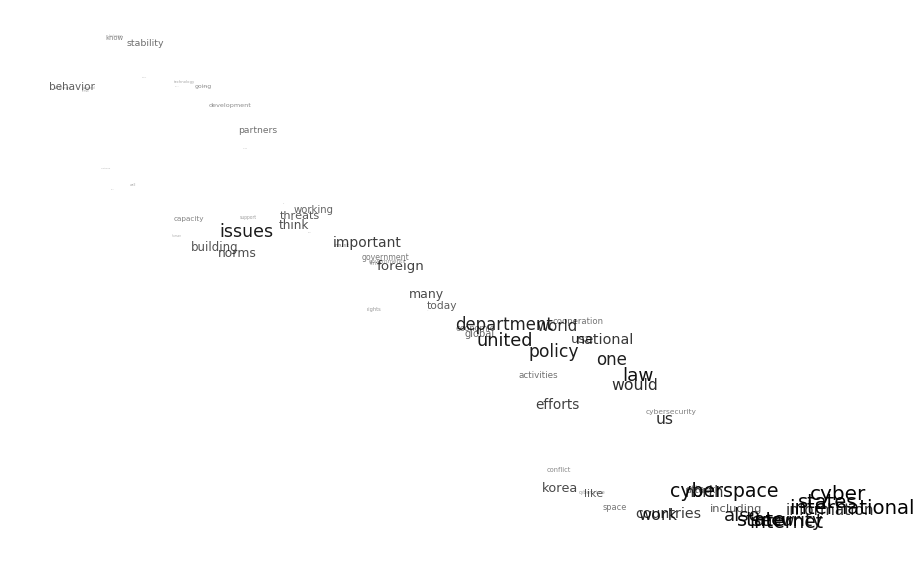

In [296]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(DOStsneWords[:, 0], DOStsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(DOStargetWords):
    ax.annotate(word, 
                (DOStsneWords[:, 0][i],DOStsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

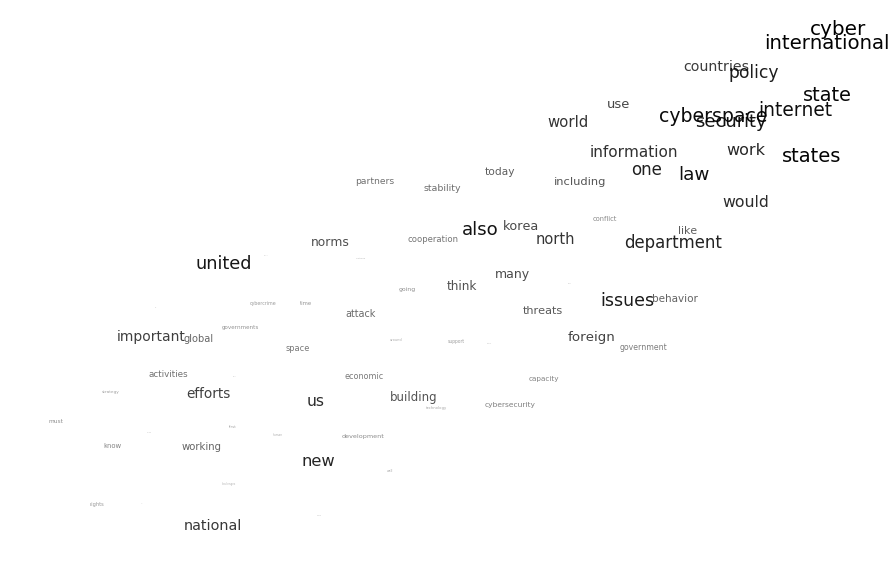

In [297]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(DHStsneWords[:, 0], DHStsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(DOStargetWords):
    ax.annotate(word, 
                (DHStsneWords[:, 0][i],DHStsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

In [298]:
keywords = ['cyber', 'cyberspace', 'security', 'international', 'national', 'cybersecurity', 'state', 'states' ]

In [299]:
#ALL SPEECHES
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = speechesW2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, speechesW2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

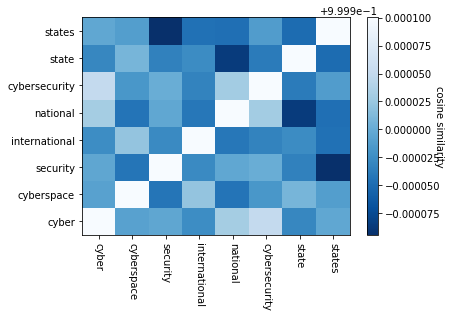

In [300]:
#ALL SPEECHES
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='Blues_r')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')

In [301]:
#DOS SPEECHES
DOSheatmapMatrix = []
for DOStagOuter in keywords:
    DOScolumn = []
    DOStagVec = DOSspeechesW2V.wv[DOStagOuter].reshape(1, -1)
    for DOStagInner in keywords:
        DOScolumn.append(sklearn.metrics.pairwise.cosine_similarity(DOStagVec, DOSspeechesW2V.wv[DOStagInner].reshape(1, -1))[0][0])
    DOSheatmapMatrix.append(DOScolumn)
DOSheatmapMatrix = np.array(DOSheatmapMatrix)

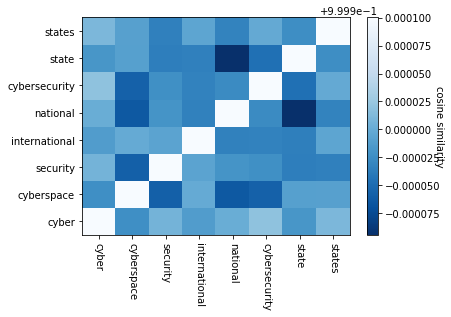

In [302]:
#DOS SPEECHES
fig, ax = plt.subplots()
DOShmap = ax.pcolor(DOSheatmapMatrix, cmap='Blues_r')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(DOSheatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(DOSheatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('dos.png', bbox_inches='tight')

In [303]:
#DHS
DHSheatmapMatrix = []
for DHStagOuter in keywords:
    DHScolumn = []
    DHStagVec = DHSspeechesW2V.wv[DHStagOuter].reshape(1, -1)
    for DHStagInner in keywords:
        DHScolumn.append(sklearn.metrics.pairwise.cosine_similarity(DHStagVec, DHSspeechesW2V.wv[DHStagInner].reshape(1, -1))[0][0])
    DHSheatmapMatrix.append(DHScolumn)
DHSheatmapMatrix = np.array(DHSheatmapMatrix)

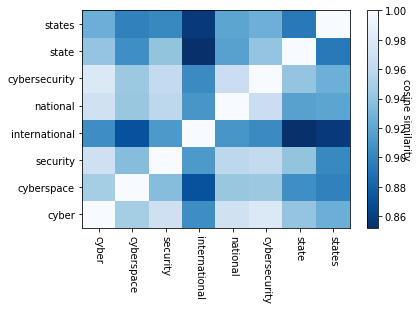

In [304]:
#DHS
fig, ax = plt.subplots()
hmap = ax.pcolor(DHSheatmapMatrix, cmap='Blues_r')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(DHSheatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(DHSheatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('dhs.png', bbox_inches='tight')

# POS TAGGING

In [305]:
import os.path
import zipfile
import subprocess
import io
import tempfile

In [306]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


In [307]:
import lucem_illud.stanford as stanford

In [308]:
speechesDF['POS-sents'] = speechesDF['tokenized-sents'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [309]:
#DOS SPEECHES
countTarget = 'NN'
targetCounts = {}
for entry in speechesDF['POS-sents'][0:31]:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('cyber', 429),
 ('cyberspace', 247),
 ('s', 244),
 ('law', 225),
 ('security', 162),
 ('policy', 159),
 ('world', 112),
 ('information', 105),
 ('–', 103),
 ('Internet', 97),
 ('behavior', 88),
 ('today', 83),
 ('stability', 82),
 ('state', 80),
 ('cooperation', 78),
 ('internet', 76),
 ('capacity', 74),
 ('space', 74),
 ('attack', 73),
 ('time', 73)]

In [310]:
#DHS SPEECHES
countTarget = 'NN'
targetCounts = {}
for entry in speechesDF['POS-sents'][32:42]:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('cyber', 120),
 ('cybersecurity', 116),
 ('government', 105),
 ('information', 81),
 ('security', 60),
 ('DHS', 57),
 ('sector', 55),
 ('nation', 52),
 ('year', 43),
 ('s', 38),
 ('threat', 32),
 ('–', 29),
 ('sharing', 28),
 ('infrastructure', 28),
 ('today', 26),
 ('country', 25),
 ('number', 25),
 ('way', 25),
 ('world', 24),
 ('computer', 22)]

In [311]:
#DOS SPEECHES
NTarget = 'JJ'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][0:31]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'domestic', 'international', 'stable', 'secure', 'key', 'peaceful', 'reliable', 'military', 'tame', 'mainstream', 'accessible'}


In [312]:
#DHS SPEECHES
NTarget = 'JJ'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][32:42]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'civilian'}


In [313]:
#DOS SPEECHES
NTarget = 'NNS'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][0:31]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'opportunities', 'challenges'}


In [314]:
#DHS SPEECHES
NTarget = 'NN'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][32:42]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'“', 'impact', 'Connect—because'}


In [315]:
#DOS SPEECHES
NTarget = 'VB'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][0:31]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'rule', 'keep', 'prevent'}


In [316]:
#DHS SPEECHES
NTarget = 'VB'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][32:42]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'make', 'secure'}


In [317]:
#DOS SPEECHES
NTarget = 'PRP$'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][0:31]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'its', 'our'}


In [318]:
#DHS SPEECHES
NTarget = 'PRP$'
Word = 'cyberspace'
NResults = set()
for entry in speechesDF['POS-sents'][32:42]:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'our'}


# Networks

In [390]:
import networkx as nx

In [391]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [392]:
g = wordCooccurrence(speechesDF['normalized-sents'].sum())

In [393]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [394]:
speechesVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
speechesVects_incidence = speechesVectorizer.fit_transform(speechesDF['text'])

In [395]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [396]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((speechesVectorizer.get_feature_names()[i] for i in range(speechesVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(speechesVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, speechesVectorizer.get_feature_names()[w], {'weight' : speechesVects_incidence[d, w]}) for d, w in zip(*speechesVects_incidence.nonzero())))

In [397]:
gDoc = contractNetwork(g_2mode, 'doc')

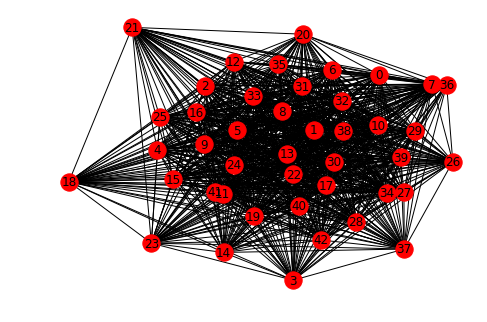

In [501]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()})


In [399]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3867
Number of edges: 2598318
Average degree: 1343.8417


In [400]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.1781921997230516

In [401]:
g = wordCooccurrence(speechesDF['normalized-sents'].sum())

In [402]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 30])
g.remove_nodes_from(list(nx.isolates(g))) 
giant = max(nx.connected_component_subgraphs(g), key=len) 
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 231
Average degree:   4.7629


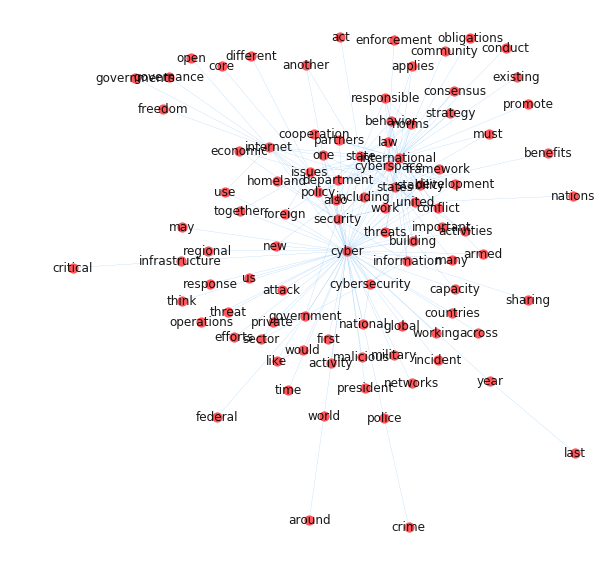

In [403]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 85,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')
fig.savefig('wordnetwork.png')

In [404]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 300]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 231
Average degree:   4.7629


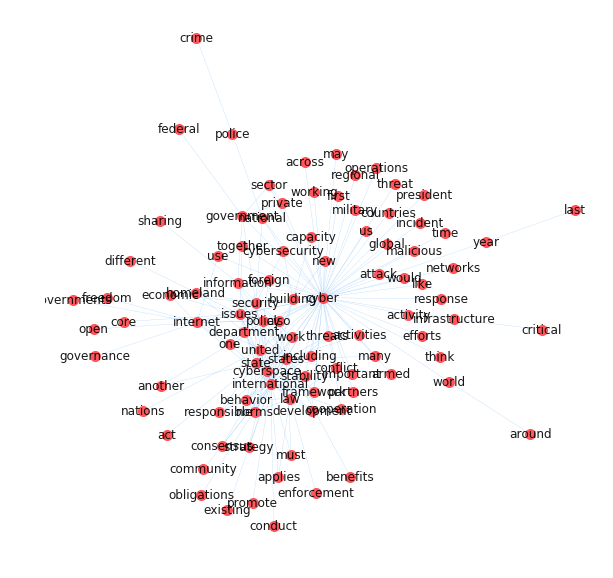

In [405]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [483]:
cyberspaceNeighbors = giant.neighbors('cyberspace')
g_cyberspace = giant.subgraph(cyberspaceNeighbors)
print(nx.info(g_cyberspace))

Name: 
Type: SubGraph
Number of nodes: 21
Number of edges: 91
Average degree:   8.6667


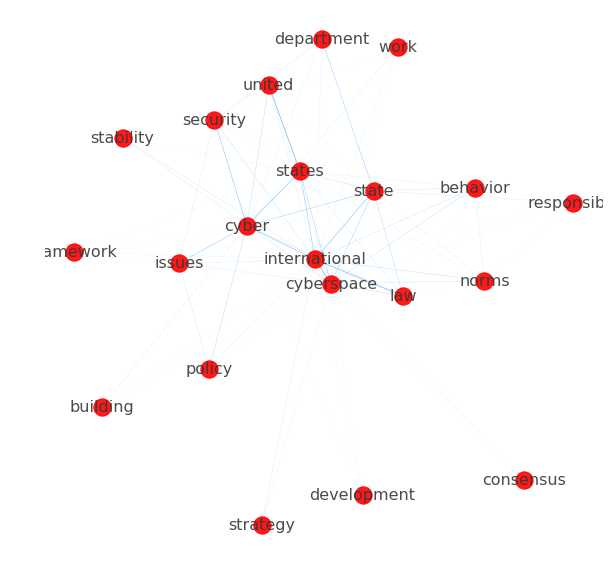

In [486]:
layout_cyberspace = nx.spring_layout(g_cyberspace, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_cyberspace.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyberspace.edges(data = True)))
nx.draw(g_cyberspace, ax = ax, pos = layout_cyberspace, labels = {n:n for n in g_cyberspace.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyberspace.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))
fig.savefig('cyberspacenetwork.png', bbox_inches='tight')

In [423]:
cyberspaceNeighbors = gWord.neighbors('cyberspac')
cyberspaceNeighborsPlus1 = set(cyberspaceNeighbors)
for n in cyberspaceNeighbors:
    cyberspaceNeighborsPlus1 |= set(giant.neighbors(n))


In [424]:
g_cyberspace2 = giant.subgraph(cyberspaceNeighborsPlus1)
print(nx.info(g_cyberspace2))

Name: 
Type: SubGraph
Number of nodes: 40
Number of edges: 50
Average degree:   2.5000


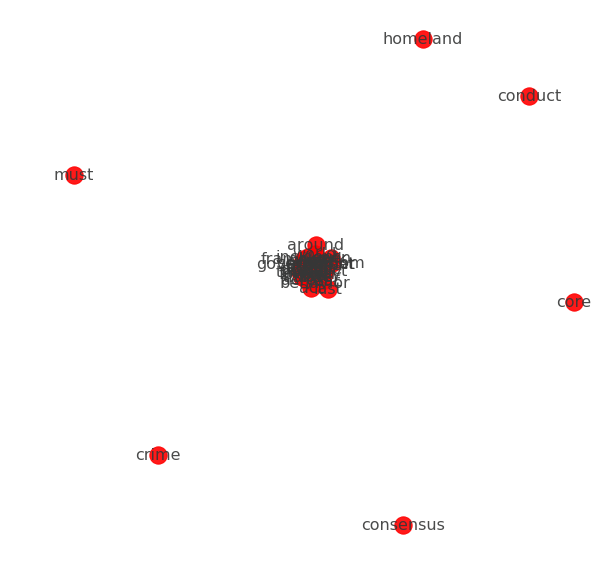

In [427]:
layout_cyberspace = nx.spring_layout(g_cyberspace2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_cyberspace = nx.eigenvector_centrality(g_cyberspace2)
maxC = max(centralities_cyberspace.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_cyberspace2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyberspace2.edges(data = True)))
nx.draw(g_cyberspace2, ax = ax, pos = layout_cyberspace, labels = {n:n for n in g_cyberspace2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyberspace2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))
fig.savefig('cyberspacenetwork2.png')

In [428]:
cyberNeighbors = giant.neighbors('cyber')
g_cyber = giant.subgraph(cyberNeighbors)
print(nx.info(g_cyber))

Name: 
Type: SubGraph
Number of nodes: 65
Number of edges: 177
Average degree:   5.4462


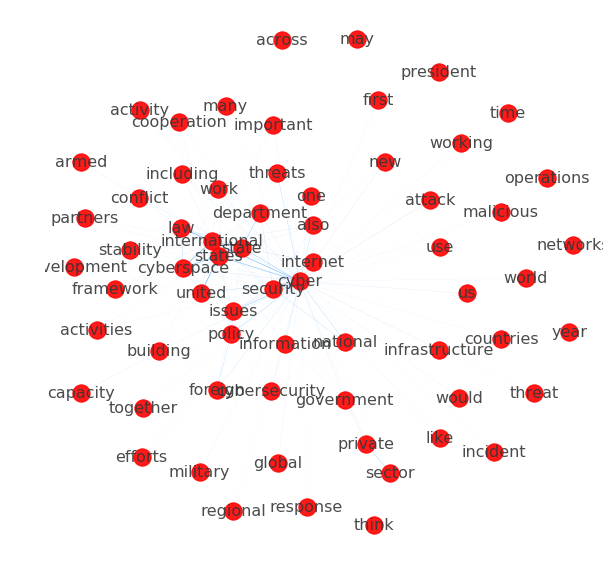

In [429]:
layout_cyber = nx.spring_layout(g_cyber, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_cyber.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyber.edges(data = True)))
nx.draw(g_cyber, ax = ax, pos = layout_cyber, labels = {n:n for n in g_cyber.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyber.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))
fig.savefig('cybernet.png')

In [430]:
cyberNeighbors = gWord.neighbors('cyber')
cyberNeighborsPlus1 = set(cyberNeighbors)
for n in cyberNeighbors:
    cyberNeighborsPlus1 |= set(giant.neighbors(n))


In [431]:
g_cyber2 = giant.subgraph(cyberNeighborsPlus1)
print(nx.info(g_cyber2))

Name: 
Type: SubGraph
Number of nodes: 39
Number of edges: 22
Average degree:   1.1282


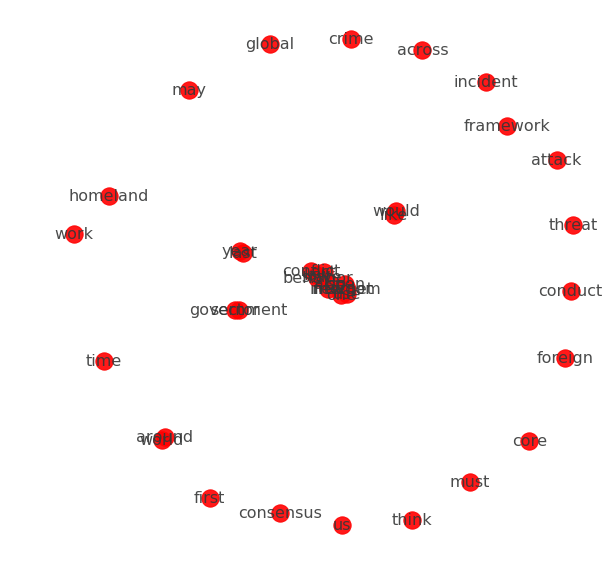

In [432]:
layout_cyber = nx.spring_layout(g_cyber2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_cyber = nx.eigenvector_centrality(g_cyber2)
maxC = max(centralities_cyber.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_cyber2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyber2.edges(data = True)))
nx.draw(g_cyber2, ax = ax, pos = layout_cyber, labels = {n:n for n in g_cyber2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyber2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))
fig.savefig('cyber2network.png')

# Network Statistics

In [433]:
dcentralities = nx.degree_centrality(giant)

In [434]:
dcentralities['cyber']

0.6875

In [435]:
max(dcentralities.items(), key = lambda x : x[1])

('cyber', 0.6875)

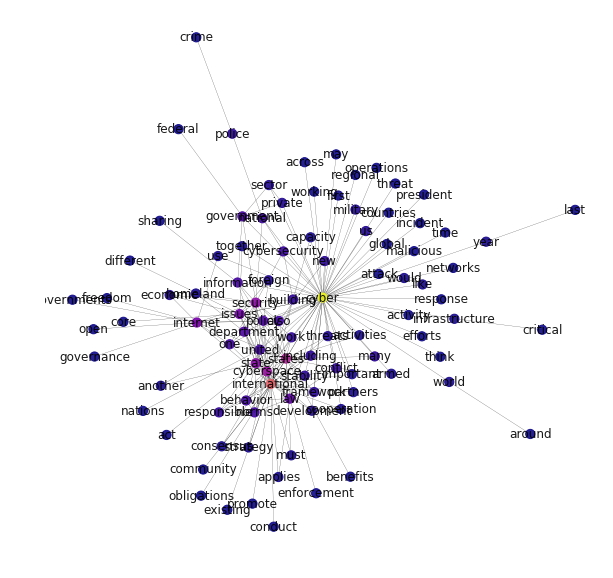

In [436]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 85,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

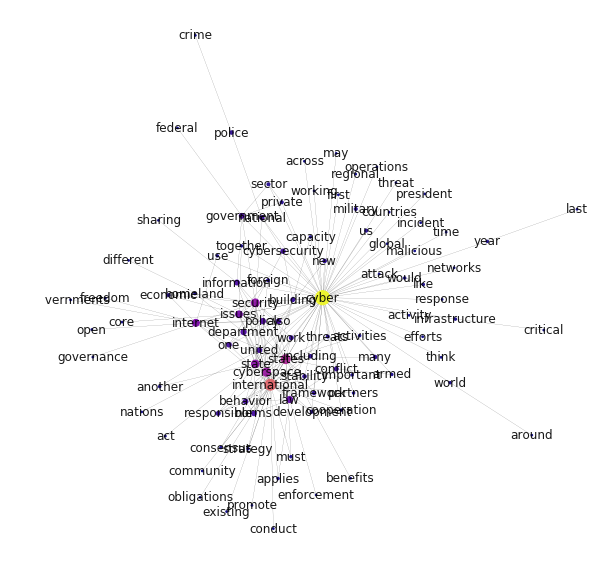

In [439]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

In [440]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('cyber', 0.6875),
 ('international', 0.40625),
 ('states', 0.2708333333333333),
 ('cyberspace', 0.22916666666666666),
 ('security', 0.20833333333333331),
 ('state', 0.19791666666666666),
 ('internet', 0.16666666666666666),
 ('issues', 0.15625),
 ('law', 0.125),
 ('policy', 0.09375)]

In [441]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('last', 0.010416666666666666),
 ('countries', 0.010416666666666666),
 ('obligations', 0.010416666666666666),
 ('different', 0.010416666666666666),
 ('networks', 0.010416666666666666),
 ('governments', 0.010416666666666666),
 ('may', 0.010416666666666666),
 ('core', 0.010416666666666666),
 ('time', 0.010416666666666666),
 ('nations', 0.010416666666666666)]

In [442]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [443]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 105
Average degree:   8.4000


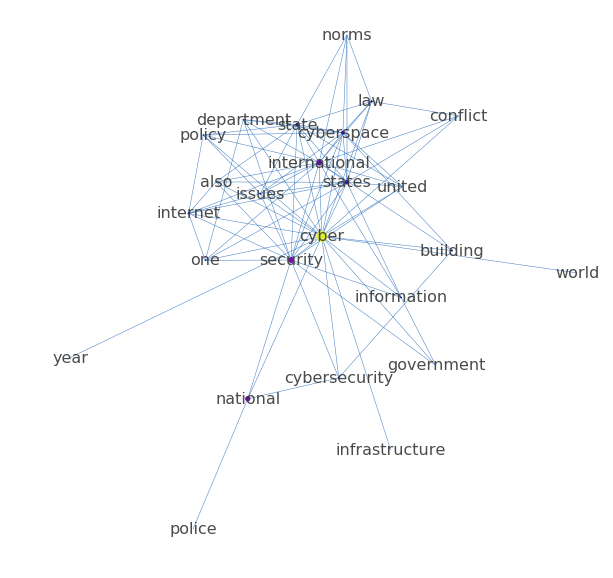

In [482]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )
fig.savefig('cyberfilteredcentralities.png', bbox_inches='tight')

# POS Networks

In [449]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [460]:
gNN = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN')

In [461]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2386
Number of edges: 32545
Average degree:  27.2800


In [462]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 150]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 70
Number of edges: 1921
Average degree:  54.8857


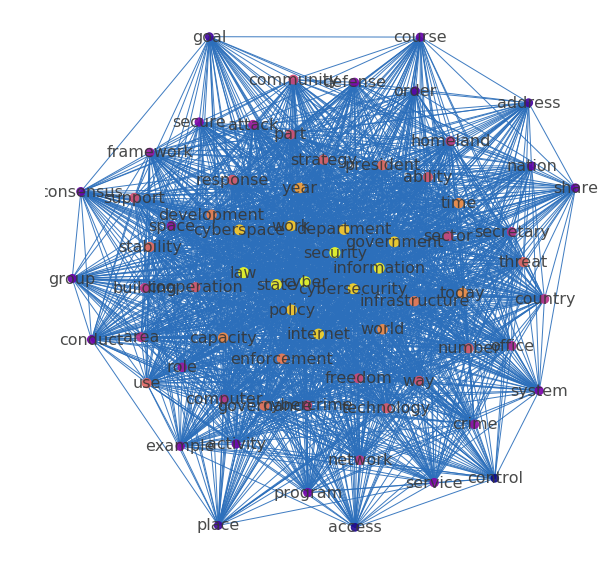

In [463]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [464]:
gNV = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN', 'VB')

In [465]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2564
Number of edges: 37849
Average degree:  29.5234


In [466]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.print(nx.info(gNV))nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [467]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2564
Number of edges: 5817
Average degree:   4.5374


In [468]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [469]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 136
Average degree:   7.1579


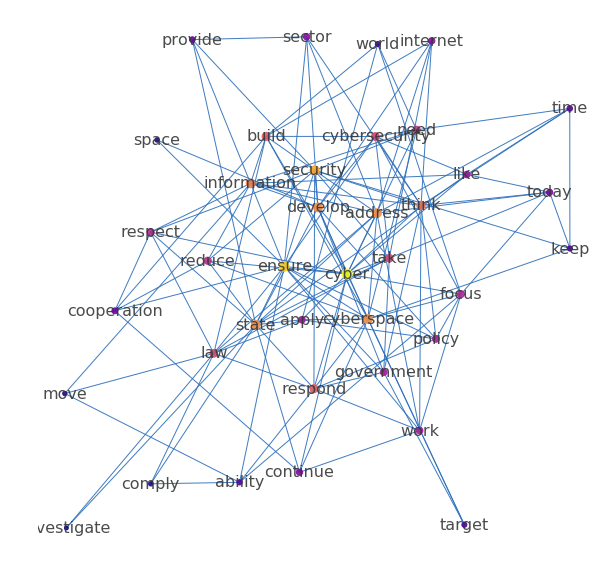

In [470]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [471]:
g_i = gNV.subgraph(['cyberspace'] + list(gNV.neighbors('cyberspace')))

In [472]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


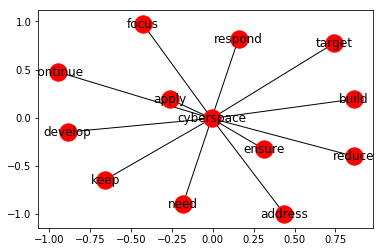

In [474]:
nx.draw_networkx(g_i)

In [475]:
gNJ = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3454
Number of edges: 76467
Average degree:  44.2774


In [476]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 259
Average degree:  20.7200


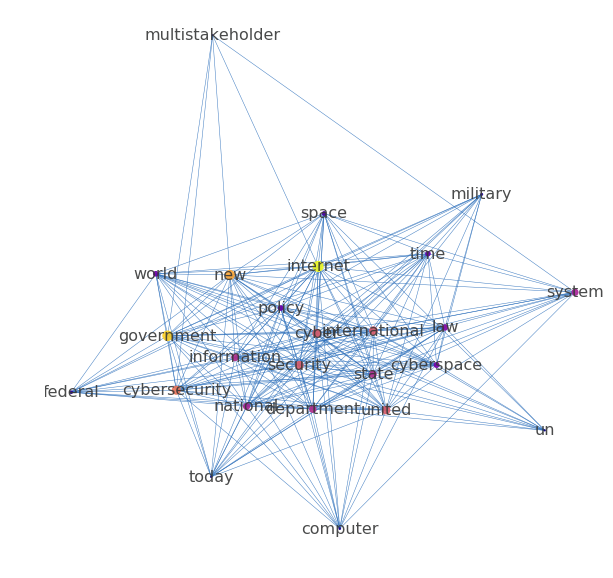

In [481]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )
fig.savefig('cyberNNJJ.png', bbox_inches='tight')

# Word Embedding - Linguistic Change

Unfortunately did not work.

In [332]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [333]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(speechesDF['normalized-sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [336]:
import copy
rawEmbeddings, comparedEmbeddings = compareModels(speechesDF, 'date')

In [337]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0][word],
                                                                             embed[word])[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [340]:
targetWord = 'cyber'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.0985063  -0.00164299 -0.185269   -0.04320831 -0.01203772 -0.15040593
 -0.00692943  0.07677533  0.04569675  0.01609543  0.08270507  0.136752
 -0.09256852  0.12293545 -0.07262678  0.15233095  0.04695173 -0.19925487
  0.00806423  0.03673508  0.00176742 -0.01589639  0.01914119  0.04033907
 -0.03218735 -0.14299417 -0.05353141  0.14976332  0.23655494 -0.14051226
 -0.043496    0.1803327   0.05876467 -0.1389825   0.08759805  0.10252663
  0.04435438  0.03571796 -0.15126075  0.2603274  -0.00977052  0.05129547
  0.07615491  0.1566226  -0.07138486  0.09896002 -0.08024263  0.11595329
  0.18022428 -0.10368341  0.04270145 -0.04171755 -0.10467057  0.01747881
 -0.09887711 -0.12765187 -0.18789765 -0.04455504 -0.07878905  0.02471005
  0.0917097  -0.02111319 -0.0512031   0.0620825   0.05621397 -0.02661166
 -0.00514587 -0.092871   -0.14734946 -0.11614435  0.02831703  0.02042952
 -0.01847643  0.01622977  0.15104838  0.03371023  0.04018567 -0.00542549
  0.01517598  0.15942441 -0.00820118 -0.07423347 -0.15600045  0.00854887
 -0.04683179 -0.11550772  0.0135316   0.01870272  0.07548663  0.15208614
  0.12424039 -0.10506449 -0.17426851 -0.01858    -0.23039602 -0.03333092
 -0.04995519 -0.03421409  0.05297091 -0.05574808].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [341]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cats[0]][0][word], embed[word])[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [342]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1889 words to compare


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.09738407 -0.00150913 -0.18438676 -0.0432023  -0.01319919 -0.15227295
 -0.00850579  0.07758968  0.04693383  0.01805782  0.08085589  0.13717662
 -0.09189209  0.12345676 -0.07484362  0.15323165  0.04742696 -0.19979194
  0.00662075  0.0382771   0.0031147  -0.01539654  0.01916393  0.04104773
 -0.0332719  -0.14353618 -0.05394359  0.1514123   0.23529002 -0.14299408
 -0.04255619  0.17799477  0.05885996 -0.13682106  0.08700439  0.10045642
  0.0439283   0.03602987 -0.15071625  0.26209307 -0.00861776  0.05132835
  0.07728726  0.1551228  -0.07147669  0.10118211 -0.07968374  0.11875353
  0.17788771 -0.1051582   0.04275746 -0.04199007 -0.10352217  0.01864926
 -0.09723757 -0.12615488 -0.18861939 -0.04525015 -0.07866921  0.02227142
  0.08994906 -0.022073   -0.05166207  0.06047466  0.05606942 -0.02629817
 -0.00230846 -0.09150326 -0.1488394  -0.11830743  0.02793156  0.01916626
 -0.01759333  0.0159014   0.14904398  0.03451312  0.04175364 -0.00545574
  0.01762781  0.15999138 -0.00881562 -0.07555324 -0.15680017  0.0067104
 -0.04503568 -0.11488334  0.01074757  0.0201542   0.07622184  0.15133822
  0.12498397 -0.10508703 -0.17299727 -0.02042945 -0.23000471 -0.03240155
 -0.05152504 -0.03444455  0.05195479 -0.05669747].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [343]:
wordDivergences[:10]

NameError: name 'wordDivergences' is not defined